<a href="https://colab.research.google.com/github/homerabbitsky/HelloAI/blob/main/assignment8_pt2_GAN_pytorch1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 170498071/170498071 [00:01<00:00, 104697448.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, 

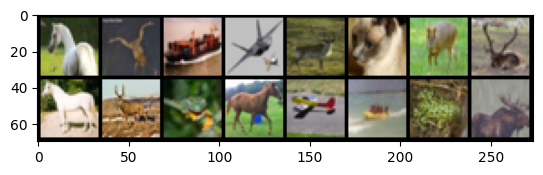

horse frog  ship  plane deer  cat   deer  deer  horse deer  frog  horse plane ship  frog  deer 
[1,  2000] loss: 1.954
[2,  2000] loss: 1.299
[3,  2000] loss: 1.006
[4,  2000] loss: 0.810
[5,  2000] loss: 0.659
Finished Training
Accuracy for class: plane is 69.5 %
Accuracy for class: car   is 87.2 %
Accuracy for class: bird  is 53.1 %
Accuracy for class: cat   is 44.1 %
Accuracy for class: deer  is 72.1 %
Accuracy for class: dog   is 75.7 %
Accuracy for class: frog  is 89.4 %
Accuracy for class: horse is 79.9 %
Accuracy for class: ship  is 76.3 %
Accuracy for class: truck is 88.5 %


In [2]:

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

PATH = "/content/drive/MyDrive/models/classifier-vgg1.pt"
device = 'cuda'
batch_size = 16


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

# we need to test our loaded model no matter what
transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
# net = Net() # no longer need this since we aren't building our own model
net = models.vgg11() # load the pre-built (but not pre-trained) vgg11 model
net.classifier[6] = nn.Linear(4096,num_classes) # modify stock vgg11 with its 1000 classes to handle our 10 classes - https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
print(net) # display the layers in the pre-built model

loadmodelweights = False # change this to True once you have ran this cell successfully!

if loadmodelweights:
    net.load_state_dict(torch.load(PATH))
    net = net.to(device)

else:
    # we only need to load the training data if we (re)training the model
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # show images
    imshow(torchvision.utils.make_grid(images, normalize=True))

    # print labels
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    net = net.to(device)

    import torch.optim as optim

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), PATH)

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


In [9]:
# OK the previous cell setup a good "classifier", now let's build our GAN
# source: modified from https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py

from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

cudnn.benchmark = True

# flag for saving/loading
PATH_G = "/content/drive/MyDrive/models/generator-cifar10.pt"
PATH_D = "/content/drive/MyDrive/models/discriminator-cifar10.pt"
loadgan = False # change this to True once you have run this cell successfully

#checking the availability of cuda devices
device = 'cuda'
# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64
# number of channels
nc=3

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

if loadgan:
  #load weights to test the model 
  netG.load_state_dict(torch.load(PATH_G))
  netD.load_state_dict(torch.load(PATH_D))
  print(netG)
  print(netD)

else:
  print(netG)
  print(netD)

  #set manual seed to a constant get a consistent output
  manualSeed = random.randint(1, 10000)
  print("Random Seed: ", manualSeed)
  random.seed(manualSeed)
  torch.manual_seed(manualSeed)

  #loading the dataset
  dataset = dset.CIFAR10(root="./data", download=True,
                            transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

  dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

  criterion = nn.BCELoss()

  # setup optimizer
  optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

  fixed_noise = torch.randn(128, nz, 1, 1, device=device)
  real_label = 1.0 # needed to change from 1 to 1.0
  fake_label = 0.0 # needed to change from 0 to 0.0

  niter = 20
  g_loss = []
  d_loss = []

  ################################################
  # COSC 470 - HERE ARE YOUR TWO DATA STRUCTURES #
  ################################################
  confidences = []
  counts = [0]*10
  for epoch in range(niter):
      for i, data in enumerate(dataloader, 0):
          # Backprop D network: maximize log(D(x)) + log(1 - D(G(z)))
          # train with real
          netD.zero_grad()
          real_cpu = data[0].to(device)
          batch_size = real_cpu.size(0)
          label = torch.full((batch_size,), real_label, device=device)

          output = netD(real_cpu)
          errD_real = criterion(output, label)
          errD_real.backward()
          D_x = output.mean().item()

          # train with fake
          noise = torch.randn(batch_size, nz, 1, 1, device=device)
          fake = netG(noise)
          label.fill_(fake_label)
          output = netD(fake.detach())
          errD_fake = criterion(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()

          # Backprop G network: maximize log(D(G(z)))
          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          output = netD(fake)
          errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()
          
          #save the output
          if i % 50 == 0:
              print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
              print('saving the output')
              vutils.save_image(real_cpu,'/content/drive/MyDrive/output/real_samples.png', normalize=True)
              fake = netG(fixed_noise)
              vutils.save_image(fake.detach(),'/content/drive/MyDrive/output/fake_samples_epoch_%03d.png' % (epoch),normalize=True)

      ##########################################################################################################
      # COSC 470 - use the classifier from the previous code cell called "net" to classify the last            #
      # batch of fake images generated in this epoch. Then calculate the predictions and averager confidences. #
      # also increment the label counts. HINT: move the code from the next cell up to this block and modify it.#
      ##########################################################################################################
      noise = torch.randn(8, nz, 1, 1, device=device)
      imgs = netG(noise)
      transform=transforms.Compose([transforms.Resize(32, antialias=False)])
      imgs = transform(imgs)
      imshow(torchvision.utils.make_grid(imgs.cpu().detach(), normalize=True))
      output = net(imgs) # use our classifier from the first cell to classify these generated images
      output = F.softmax(output, dim=1)
      conf, predictions = torch.max(output, dim=1)  # conf has the softmx confidences, predictions has the predictions
      confidences = confidences + [c.cpu() for c in conf]
      for pred in predictions:
        counts[pred] += 1 
      # Check pointing after every epoch
      torch.save(netG.state_dict(), PATH_G)
      torch.save(netD.state_dict(), PATH_D)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


FileNotFoundError: ignored

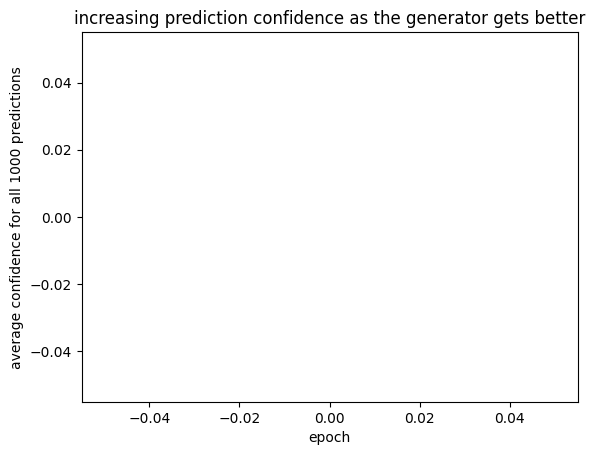

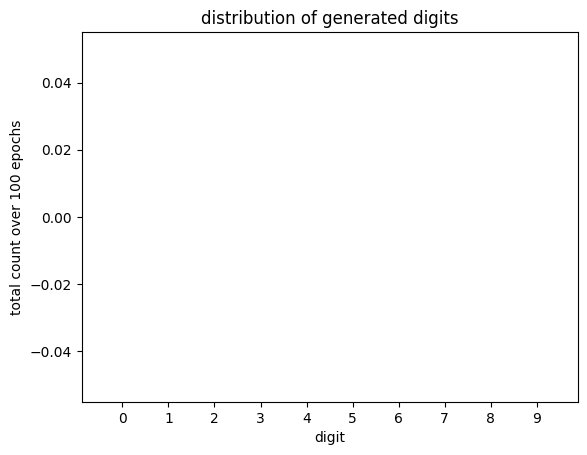

In [8]:
# now let's plot the average confidences in the predictions over the epochs
import matplotlib.pyplot as plt
plt.plot([float(c) for c in confidences])
plt.xlabel("epoch")
plt.ylabel("average confidence for all 1000 predictions")
plt.title("increasing prediction confidence as the generator gets better")
plt.show()

plt.bar([f"{x}" for x in range(10)], counts)
plt.xlabel("digit")
plt.ylabel("total count over 100 epochs")
plt.title("distribution of generated digits")
plt.show()